<H1 style="text-align: center">ECMM422 - Machine Learning</H1>
<H2 style="text-align: center">Assignment 1: Classifiers</H2>



| <font style="font-size:larger;">Date set     | <font style="font-size:larger;">Hand-in date |
|:------------------|:-----------------------------------|
|<font style="font-size:larger;"> 24th January 2019 |<font style="font-size:larger;">**  12 noon, Wednesday 5th February 2020** |

</font>

Candidate number:  <font color="red">*660030047*</font>

Marking is anonymous, so please don't write your name or reveal your identity!


The module assessment is comprised of your IPython notebooks. There will be four marked assignments, of which this is the first. All assignments will be equally weighted and therefore worth 25% of your module mark. 


Your IPython notebook should show what you did, what was the
result, and what you can conclude from the exercise. For some reports you will need to comment on a paper you have read.   Each report will be
assessed on the following criteria:

* Does it record what was done in the exercise?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

### Submitting the notebooks

Note that an electronic submission is required.  You should also submit the notebook electronically at [electronic hand-in system]( http://empslocal.ex.ac.uk/submit/).  You just need to submit the single .ipynb file that is the notebook, so you should be able to upload it directly from the directory where you have saved it on a University machine or your laptop.  If you're not sure where in your homespace it is, type <code>pwd</code> (print working directory) in a cell to find out where the notebooks are.

<b>Note: you must also submit your cover sheet and E-Submit receipt via BART to complete the submission.</b>



<div class="alert alert-info">
 Although you will undoubtedly work collaboratively in the workshops themselves, these are *individual* exercises.  The reports you write should be about the results *you* obtained, and your attention is drawn to the College and University guidelines on collaboration and plagiarism. 
 </div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Classification

In the first part of this workshop, we will work on a simple classification problem with synthetic data. The dataset has one binary target $t\in \{0,1\}$ and two features $\mathbf{x} = [x_1,x_2]$. This will allow to visualise the data and model decision boundary on 2D plots.

First, you should download and load the data in from two files on the VLE, the files should be placed in the same folder as the jupyter notebook. The files contain the $\mathbf{x}$ and $t$ values for 500 samples.

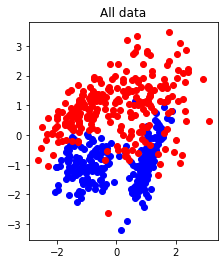

In [2]:
# we first load each file in a separate array
Xall = np.load('ecmm422_ca1_part1_X.npy')
tall = np.load('ecmm422_ca1_part1_t.npy')

# then we plot all data using matplotlib - note the indexing to select only samples from one class or the other
plt.plot(Xall[tall==0, 0], Xall[tall==0, 1], 'bo')
plt.plot(Xall[tall==1, 0], Xall[tall==1, 1], 'ro')
plt.axis('scaled')
plt.title('All data')
plt.show()

It is clear that it cannot be completely separated by a straight line, so these data are said not to be "linearly separable".

The first step in any machine learning work will be to separate and put aside a test set for final evaluation. Often this set will be sampled randomly from the available data, but for this workshop we will use a specific subset of half the data so that performance is comparable. 

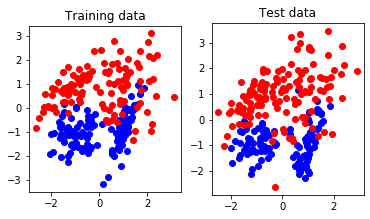

In [3]:
I = range(len(tall))    # you could change this for np.random.permutation(len(tall)) to get a random selection
                        # do not do this for this workshop as I want to be able to compare final performance. 

Itrain = I[:len(tall)//2]   # First half of indices for training
Itest = I[len(tall)//2:]    # Second half for test

Xtr = Xall[Itrain,:] # we define variables for the training set...
ttr = tall[Itrain]   

Xte = Xall[Itest,:]  # ... and for the test set
tte = tall[Itest]   

# then we plot both sets
plt.subplot(121)
plt.plot(Xtr[ttr==0, 0], Xtr[ttr==0, 1], 'bo')
plt.plot(Xtr[ttr==1, 0], Xtr[ttr==1, 1], 'ro')
plt.axis('scaled')
plt.title('Training data')

plt.subplot(122)
plt.plot(Xte[tte==0, 0], Xte[tte==0, 1], 'bo')
plt.plot(Xte[tte==1, 0], Xte[tte==1, 1], 'ro')
plt.axis('scaled')
plt.title('Test data')

# note that we would usually also label axes, but in this case the features 
# are unnamed so this would not add much information. 

plt.show()


Good. We can see in those plots that the two distributions are comparable, so we did not create a pathological split (eg, one that would contain only one class!) by accident. 

<b>NB:</b> We must <b>not</b> use the test data as part of the training process.

We will use three different algorithms in this workshop: k-NN, Neural Networks and decision trees. 

### 1.1 Classification with k-nearest neighbours
As a first step, we will try to model the dataset distribution using k-Nearest Neighbours. 
We will use the k-nearest neighbour classifier from scikit learn, which is  quite an extensive implementation of various machine learning algorithms.

In [4]:
from sklearn import neighbors

To start off, we use **all** the training data.

In [5]:
k = 5   # Choose the number of nearest neighbours

knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(Xtr, ttr)

# we can get the performance on the training set
Str = knn.score(Xtr, ttr)

# we can also calculate the performance on the test set: 
Ste = knn.score(Xte, tte)

print('Performance with k=%i,\n\t- on training set %f \n\t- on test set %f' % (k, Str, Ste))


Performance with k=5,
	- on training set 0.952000 
	- on test set 0.916000


In the following cell, we will set up a grid of points to be classified over the whole domain and then classify them with the k-nn classifier, plotting the result in the corresponding place on the grid.  This gives a nice visualisation of the classfier's performance.


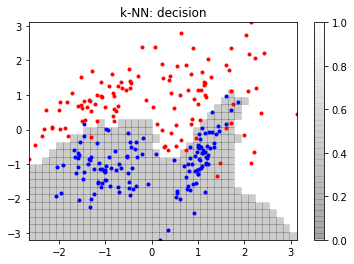

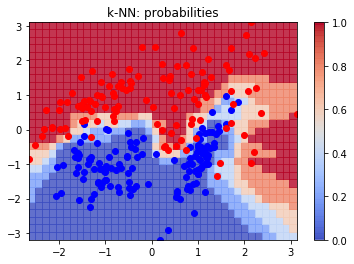

In [6]:
# we use this to calculate classification accuracy, you can as easily calculate it by hand though. 
from sklearn import metrics

def plot_decision_regions(X, t, model, label='model', show_decision=True, show_probabilities=True):
    '''
    For convenience, we will use this function to draw the decision boundaries and probabilities of the learnt 
    models. 
    Xtr: the features 
    ttr: the labels
    model: the trained model to display
    label: the name of the model (for figure captions)
    show_decision: draw decision boundary plot (default: true)
    show_probabilities: draw class probabilities (default: true)
    '''
    N, M = 40, 30   # Make these larger to get a smoother picture

    X1 = np.linspace(np.min(X[:,0]), np.max(X[:,0]), N)
    X2 = np.linspace(np.min(X[:,1]), np.max(X[:,1]), M)
    pred = np.zeros((M,N))
    prob = np.zeros((M,N,2))

    # Writing this double loop is not very efficient, but it is clear.
    for nx2, x2 in enumerate(X2):
        for nx1, x1 in enumerate(X1):
            pred[nx2, nx1] = model.predict([[x1, x2]])          # Predict expects a matrix of features
            if show_probabilities:
                prob[nx2, nx1, :] = model.predict_proba([[x1, x2]]) # Probabilities of belonging to one class
            

    if show_decision:
        plt.figure() 
        plt.pcolor(X1, X2, pred, cmap=plt.cm.gray, alpha=0.2)
        plt.colorbar()
        plt.plot(X[t==0,0], X[t==0,1], 'b.')
        plt.plot(X[t==1,0], X[t==1,1], 'r.')
        plt.axis('tight')
        plt.title('{}: decision'.format(label))

    if show_probabilities:
        # Plot the probabilites of belonging to the 1 class.
        plt.figure()
        plt.pcolor(X1, X2, prob[:,:,1], cmap=plt.cm.coolwarm, alpha=0.8)
        plt.colorbar()
        plt.plot(X[t==0,0], X[t==0,1], 'bo')
        plt.plot(X[t==1,0], X[t==1,1], 'ro')
        plt.axis('tight')
        plt.title('{}: probabilities'.format(label))
        
    plt.show()
        
plot_decision_regions(Xtr, ttr, model=knn, label='k-NN')

Above we used all the training data and guessed the value of $k$. Much better is to estimate the optimum value of $k$, but dividing the training data into a training and a <b>validation</b> set; the generalisation error is then estimated on the validation set and the $k$ giving the minimum error is used for making predictions about unknown data.

Better than just dividing the training data into two is to use $k$ fold <b>cross validation</b> (don't confuse the $k$ in $k$ cross validation with the $k$ in $k$ nearest neighbours!)

The following cell shows how the sklearn routines may be used to produce training and validation sets automatically. More information at <http://scikit-learn.org/stable/modules/cross_validation.html>.  Don't worry about the deprecation warnings!

In [7]:
from sklearn.model_selection import KFold

# Make our 'training data' of 10 examples, each of two columns.
# These have just got integers in so that you can easily see which 
# examples have been selected.
X = np.vstack((np.arange(10), np.arange(10))).T + 10
t = np.arange(10)+100   # Targets
print("Features")
print(X)
print("Targets")
print(t)
print()
print()

kf = KFold(n_splits=5, shuffle=True)    # 5 fold CV here.

fold = 0
for train, validation in kf.split(X):
    print('-------- Fold', fold)
    print('Train')
    print(X[train])
    print(t[train])
    print('Test')
    print(X[validation])
    print(t[validation])
    fold += 1
    # Notice that each training set consists of 8 of the 10 examples 
    # and the validation set is the remaining 2.
    # You should train the model with X[train] and t[train]
    # and estimate the generalisation error on X[validation] and 
    # t[validation].  Don't forget to average the validation error 
    # over all the folds - you can also estimate the standard deviation 
    # to get error bars on the validation error!


Features
[[10 10]
 [11 11]
 [12 12]
 [13 13]
 [14 14]
 [15 15]
 [16 16]
 [17 17]
 [18 18]
 [19 19]]
Targets
[100 101 102 103 104 105 106 107 108 109]


-------- Fold 0
Train
[[10 10]
 [11 11]
 [12 12]
 [13 13]
 [14 14]
 [15 15]
 [17 17]
 [18 18]]
[100 101 102 103 104 105 107 108]
Test
[[16 16]
 [19 19]]
[106 109]
-------- Fold 1
Train
[[10 10]
 [11 11]
 [12 12]
 [13 13]
 [15 15]
 [16 16]
 [17 17]
 [19 19]]
[100 101 102 103 105 106 107 109]
Test
[[14 14]
 [18 18]]
[104 108]
-------- Fold 2
Train
[[12 12]
 [13 13]
 [14 14]
 [15 15]
 [16 16]
 [17 17]
 [18 18]
 [19 19]]
[102 103 104 105 106 107 108 109]
Test
[[10 10]
 [11 11]]
[100 101]
-------- Fold 3
Train
[[10 10]
 [11 11]
 [12 12]
 [14 14]
 [16 16]
 [17 17]
 [18 18]
 [19 19]]
[100 101 102 104 106 107 108 109]
Test
[[13 13]
 [15 15]]
[103 105]
-------- Fold 4
Train
[[10 10]
 [11 11]
 [13 13]
 [14 14]
 [15 15]
 [16 16]
 [18 18]
 [19 19]]
[100 101 103 104 105 106 108 109]
Test
[[12 12]
 [17 17]]
[102 107]


Make a plot of the training and validation errors as $k$ varies from 1 to, say, 50.  Here, just use the number of misclassified samples as the error, but you could also use the cross entropy (how do they differ?). 
<div style="text-align: right"><b>[10 marks]</b></div>

*  What is the best value of $k$?  
*  What is the error on the **test** set with the best $k$?
*  Make a plot of the decision regions (as above) with the best $k$
*  What can you say about the performance of the classifier when $k$ is too large or too small?
*  How do you think the optimum $k$ will vary if the amount of training data available is larger or smaller than 250 points?  Can you test your hypothesis?
<div style="text-align: right"><b>[10 marks]</b></div>

In [8]:
def kTrainer(lower=1, upper=51, folds=10):
    
    # List to store results.
    results = []

    # Repeat for different values of k.
    for k in range(lower, upper):

        # Split data.
        kf = KFold(n_splits=folds, shuffle=True, random_state=0)

        # Variables to hold combined score of classifier
        trainScore = 0
        validationScore = 0
        
        # Runs loop for every fold.
        for train, validation in kf.split(Xtr):

            # Train classifier and work out score.
            knn = neighbors.KNeighborsClassifier(n_neighbors=k)
            knn.fit(Xtr[train], ttr[train])
            trainScore += knn.score(Xtr[train], ttr[train])
            validationScore += knn.score(Xtr[validation], ttr[validation])

        # Compute averages
        trainScore /= folds
        validationScore /= folds

        # Append results.
        results.append((k, 1-trainScore, 1-validationScore))

    return np.array(results)

def plotKTrainer(results):
    plt.plot(results[:,0], results[:,1], '.-', label='Training')
    plt.plot(results[:,0], results[:,2], '.-',label='Validation')
    plt.xlabel('K')
    plt.ylabel('Error')
    plt.legend(loc='lower right')
    plt.show()
    
def bestK(results):
    index = np.argmin(results, axis=0)[2]
    best = results[index]
    print('Best k is', best[0])
    print('Validation error is', best[2])
    return best[0]
    
def testError(k):
    knn = neighbors.KNeighborsClassifier(n_neighbors=int(k))
    knn.fit(Xtr, ttr)
    testError = 1 - knn.score(Xte, tte)
    print('Error for test set:', testError)
    return knn

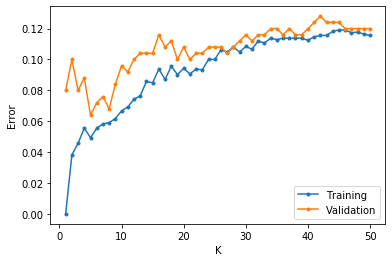

In [9]:
# Plot graph of 
results = kTrainer()
plotKTrainer(results)

In [10]:
# Best value of k.
k = bestK(results)

Best k is 5.0
Validation error is 0.06400000000000006


In [11]:
# Error on the test set
knn = testError(k)

Error for test set: 0.08399999999999996


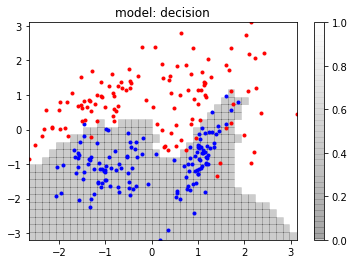

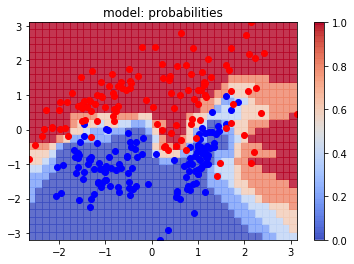

In [12]:
plot_decision_regions(Xtr, ttr, knn)

In [13]:
# When k is large, a simple model will be created, this leads to underfitting.
# The data will have a high variance and a low bias.
print('K is large')
testError(30);

# When k is small, a complex model is created, this leads to overfitting.
# The data will have a high variance and a low bias.
print('\n' + 'K is small')
testError(1);

K is large
Error for test set: 0.10399999999999998

K is small
Error for test set: 0.07999999999999996


In [14]:
# I think the optimum k will decrease when there is a small number of data points as for example below 250.
# The data will be less dense and therefore with a large value of k will include points that are
# far away and therefore be unaccurate.

# I think the opposite will be true when using more points.
tempXtr = Xtr
tempttr = ttr

print('Using 50 points.')
indexs = np.random.randint(0, 250, 50)
Xtr = Xall[indexs]
ttr = tall[indexs]
results = kTrainer(upper=20)
bestK(results)

print('\n' + 'Using 500 points.')
Xtr = Xall
ttr = tall
results = kTrainer(upper=30)
bestK(results)

Xtr = tempXtr
ttr = tempttr

Using 50 points.
Best k is 4.0
Validation error is 0.08000000000000007

Using 500 points.
Best k is 9.0
Validation error is 0.07600000000000018


In [15]:
# I was correct on both assumptions. With fewer data points the best k is reduced and with more data points
# the optimum k was slightly higher.

### 1.2 Multi-layer perceptrons (MLP)

Multi-layer perceptrons are the sorts of neural networks that have been described in lectures.  In this section we'll use an MLP with weight decay regularisation to classify the same data again. 

The next cell sets up an MLP with 5 hidden units and the given regularisation constant ($\alpha$), trains it a few times from random starting places to find the best minimum (because $E(\mathbf{w})$ may have local minima) and uses it to classify points on a grid as above.

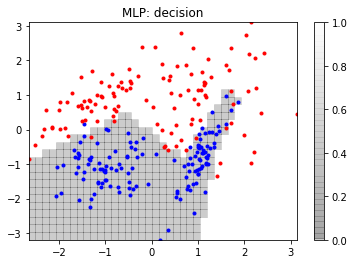

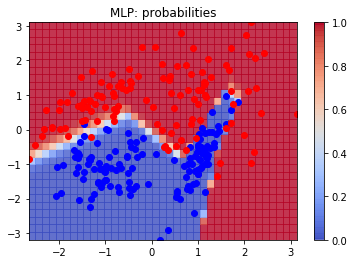

Performance with k=5,
	- on training set 0.972000 
	- on test set 0.896000


In [16]:
# load the Multi-Layer Perceptron class from Scikit-Learn
from sklearn.neural_network import MLPClassifier

# because initialisation is random, we train 10 times and take the best model (according to *training* error)
Ebest = np.Inf
for n in range(10):
    mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,))
    mlp.fit(Xtr, ttr)
    if mlp.loss_ < Ebest:
        mlpbest = mlp
        Ebest = mlp.loss_
mlp = mlpbest


plot_decision_regions(X=Xtr, t=ttr, model=mlp, label='MLP', show_decision=True, show_probabilities=True)

Ste = mlp.score(Xte, tte)
Str = mlp.score(Xtr, ttr)
print('Performance with k=%i,\n\t- on training set %f \n\t- on test set %f' % (k, Str, Ste))
plt.show()

Experiment with different values of the regularisation constant, plotting the decision boundaries to visualise how the regularisation forces a smooth or more wiggly boundary.  Remember to vary $\alpha$ on a logarithmic scale and it could range between $10^{-16}$ (effectively 0) and $1$. 

<div style="text-align: right"><b>[5 marks]</b></div>

In [17]:
def plotVariableAlpha(alpha):
    # because initialisation is random, we train 10 times and take the best model (according to *training* error)
    Ebest = np.Inf
    for n in range(10):
        mlp = MLPClassifier(solver='lbfgs', alpha=alpha, hidden_layer_sizes=(5,))
        mlp.fit(Xtr, ttr)
        if mlp.loss_ < Ebest:
            mlpbest = mlp
            Ebest = mlp.loss_
    mlp = mlpbest


    plot_decision_regions(X=Xtr, t=ttr, model=mlp, label='Alpha: %s' % alpha, show_decision=True, show_probabilities=False)

    plt.show()

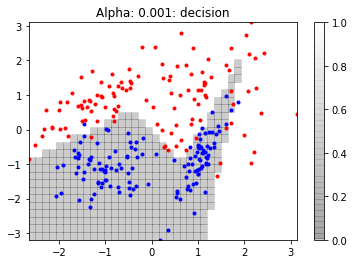

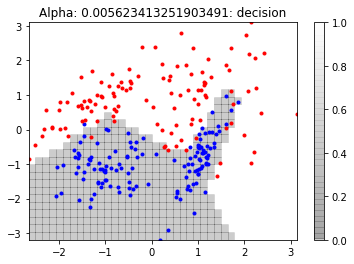

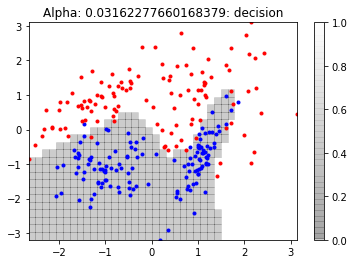

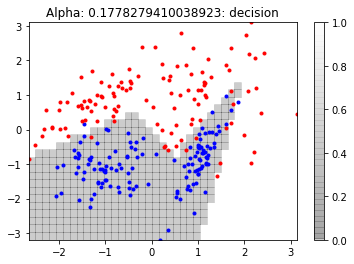

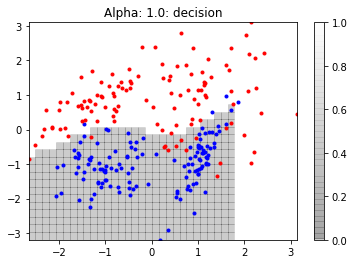

In [18]:
for i in np.logspace(-3, 0, 5):
    plotVariableAlpha(i)

In [19]:
# When alpha is small, the resultant decision boundary contains many curves and is flexible to fit
# around the data. When alpha is large then the boundary becomes more smooth.

Use cross-validation to choose the best value of the regularisation constant for these data.   Plot the training and validation data errors versus $\alpha$.  How well does the validation error correspond to the actual test error?

<div style="text-align: right"><b>[5 marks]</b></div>

In [20]:
def alphaTrainer(steps=30, trials=10, folds=10):
    
    # List to store results.
    results = []

    # Repeat for different values of k.
    for alpha in np.logspace(-3, 0, steps):

        # Split data.
        kf = KFold(n_splits=folds, shuffle=True, random_state=0)

        # Variables to hold combined score of classifier
        trainScore = 0
        validationScore = 0

        # Runs loop for every fold.
        for train, validation in kf.split(Xtr):

            Ebest = np.Inf
            for n in range(trials):
                mlp = MLPClassifier(solver='lbfgs', alpha=alpha, hidden_layer_sizes=(5,))
                mlp.fit(Xtr[train], ttr[train])
                if mlp.loss_ < Ebest:
                    mlpbest = mlp
                    Ebest = mlp.loss_
            mlp = mlpbest

            trainScore += mlp.score(Xtr[train], ttr[train])
            validationScore += mlp.score(Xtr[validation], ttr[validation])

        # Compute averages
        trainScore /= folds
        validationScore /= folds

        # Append results.
        results.append((alpha, 1-trainScore, 1-validationScore))
        
    return np.array(results)

def plotAlpha(results):
    plt.plot(results[:,0], results[:,1], '.-', label='Training')
    plt.plot(results[:,0], results[:,2], '.-',label='Validation')
    plt.xlabel('Alpha')
    plt.ylabel('Error')
    plt.legend(loc='lower right')
    plt.show()
    
def bestAlpha(results):
    index = np.argmin(results, axis=0)[2]
    best = results[index]
    print('Best alpha is', best[0])
    print('Validation error is', best[2])
    return best[0]

def testError(alpha, trials=5):
    Ebest = np.Inf
    for n in range(trials):
        mlp = MLPClassifier(solver='lbfgs', alpha=alpha, hidden_layer_sizes=(5,))
        mlp.fit(Xtr, ttr)
        if mlp.loss_ < Ebest:
            mlpbest = mlp
            Ebest = mlp.loss_
    mlp = mlpbest
    
    error = 1 - mlp.score(Xte, tte)
    
    print('Error:', error)

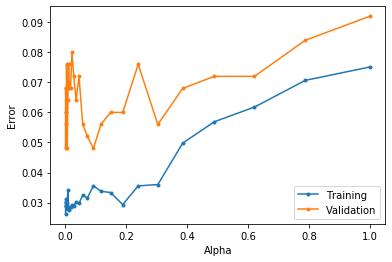

In [21]:
results = alphaTrainer()
plotAlpha(results)

In [22]:
alpha = bestAlpha(results)

Best alpha is 0.006723357536499335
Validation error is 0.04799999999999982


In [23]:
testError(alpha)

Error: 0.10399999999999998


In [24]:
# The final test error is higher than our validation data but this is expected as the validation data set is also
# used in training.

Bonus question:  How should the best value of $\alpha$ vary as the number of training examples is increased? Why? Can you test it? 

<div style="text-align: right"><b>[5 marks]</b></div>

In [25]:
# I believe the optimum value of alpha will increase with more training examples, the reason for this is because
# there will be more information and therefore a more complex neural network can be created without overfitting.

tempXtr = Xtr
tempttr = ttr

print('Using 500 points.')
Xtr = Xall
ttr = tall
results = alphaTrainer()
bestAlpha(results)

Xtr = tempXtr
ttr = tempttr

Using 500 points.
Best alpha is 0.0032903445623126675
Validation error is 0.06400000000000006


In [26]:
# The best value of alpha is increased when using more training data points.

### 1.3. Support Vector Machines (SVM)

Support vector machines (SVMs) are popular and powerful classifiers.  We'll deal with them in detail later in the module.  In the following you will use SVMs with both a "linear kernel" and with a RBF kernel.  With a linear kernel the SVM can only separate the classes with a straight line or a (hyper)plane, but an RBF kernel is nonlinear and allows the SVM to generate curved decision boundaries.  


We'll use the support vector machines in scikit learn.  Here's an example of training a SVM using a linear kernel (i.e., no non-linearity).

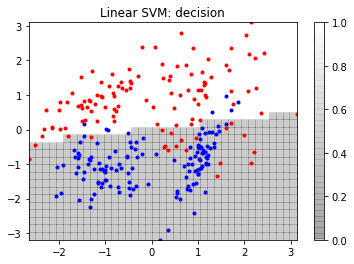

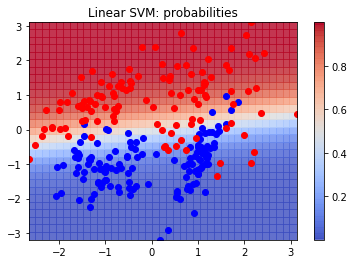

Performance:
	- on training set 0.904000 
	- on test set 0.880000


In [27]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', probability=True)    # SVM with a linear kernel, 
                                                # note that enabling probabilities is slower
svm.fit(Xtr, ttr)                     # Train it on the training data

plot_decision_regions(X=Xtr, t=ttr, model=svm, label='Linear SVM', show_decision=True, show_probabilities=True)

Ste = svm.score(Xte, tte)
Str = svm.score(Xtr, ttr)
print('Performance:\n\t- on training set %f \n\t- on test set %f' % (Str, Ste))


Now use the SVM with <code>kernel='rbf'</code> to classify the data, but with a non-linear mapping so that the decision boundary can be non-linear. 

In this case the SVM has two additional parameters $C > 0$ and $\gamma$.  $C$ is a regularisation constant that controls how strongly points that lie on the wrong side of the decision boundary are penalised.  When $C$ is large, they are heavily penalised which results in the boundary being flexible, but when it is small they are lightly penalised so the boundary tends to be straighter.  You can set the value of $C$ (and $\gamma$) with

        svm = SVC(kernel='rbf', C=1, gamma=0.1) 

The default value of $C$ is 1 and the default value of $\gamma$ is 0.1.

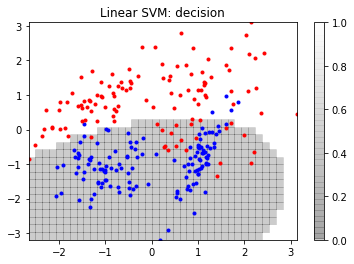

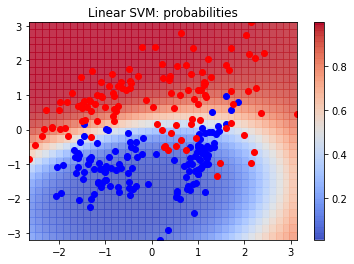

Performance with C=1.000000, gamma=0.100000,
	- on training set 0.888000 
	- on test set 0.868000


In [28]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)            # SVM with a RBF kernel
svm.fit(Xtr, ttr)                     # Train it on the training data

plot_decision_regions(X=Xtr, t=ttr, model=svm, label='Linear SVM', show_decision=True, show_probabilities=True)

Ste = svm.score(Xte, tte)
Str = svm.score(Xtr, ttr)
print('Performance with C=%f, gamma=%f,\n\t- on training set %f \n\t- on test set %f' % (1, 0.1, Str, Ste))


The $\gamma$ parameter controls the width of the RBF kernel, that is how close training samples must be to interact with each other.  When $\gamma$ is large the training samples must be close to interact and the decision boundary tends to be nonlinear, whereas when $\gamma$ is small it tends to be smooth.

Use cross validation on the *training* data to choose the best value of $C$ and $\gamma$.  Try a few values of $C$ and $\gamma$ by hand first of all to find appropriate ranges and it will  be best to vary them on a logrithmic scale.  You may care to investigate and use the sklearn helper functions for searching a grid of values for the best cross validation value: see <http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#example-svm-plot-rbf-parameters-py> or write your own!

What is the resulting accuracy on the test data and the best decision boundary?

<div style="text-align: right"><b>[15 marks]</b></div>

In [29]:
def svmTrainer(folds=10, kernel='rbf'):
    
    # List to store results.
    results = []

    # Repeat for different values of k.
    for c in np.logspace(-2, 5, 8):
        print(c)
        for g in np.logspace(-9, 3, 13):

            # Split data.
            kf = KFold(n_splits=folds, shuffle=True, random_state=0)

            # Variables to hold combined score of classifier
            trainScore = 0
            validationScore = 0

            # Runs loop for every fold.
            for train, validation in kf.split(Xtr):

                # Train classifier and work out score.
                svm = SVC(kernel=kernel, C=c, gamma=g, probability=True)
                svm.fit(Xtr[train], ttr[train])
                trainScore += svm.score(Xtr[train], ttr[train])
                validationScore += svm.score(Xtr[validation], ttr[validation])

            # Compute averages
            trainScore /= folds
            validationScore /= folds

            # Append results.
            results.append((c, g, 1-trainScore, 1-validationScore))

    return np.array(results)

def plotSVMResults(results):
    
    xticks = np.unique(results[:,1])
    yticks = np.unique(results[:,0])
    
    plt.title('Validation Error')
    plt.imshow(np.reshape(results[:,3], (len(yticks), len(xticks))), interpolation='nearest', cmap=plt.cm.hot)
    plt.xticks(np.arange(len(xticks)), xticks, rotation=45)
    plt.yticks(np.arange(len(yticks)), yticks)
    plt.xlabel('Gamma Value')
    plt.ylabel('C Value')
    plt.colorbar()
    
    plt.show()
    
def bestCGamma(results):
    index = np.argmin(results, axis=0)[3]
    best = results[index]
    print('C:', best[0])
    print('Gamma:', best[1])
    print('Validation Error:', best[3])
    return best

0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0


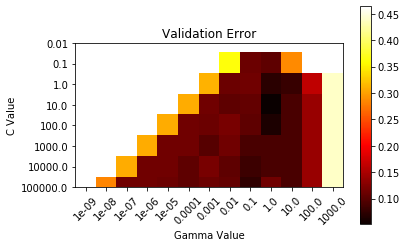

In [30]:
results = svmTrainer()
plotSVMResults(results)

In [31]:
best = bestCGamma(results);

C: 10.0
Gamma: 1.0
Validation Error: 0.05200000000000016


In [32]:
svm = SVC(kernel='rbf', C=best[0], gamma=best[1], probability=True)
svm.fit(Xtr, ttr)
print('Optimal Parameter Test Error:', 1 - svm.score(Xte, tte))

Optimal Parameter Test Error: 0.07199999999999995


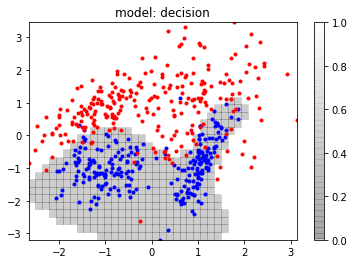

In [33]:
plot_decision_regions(Xall, tall, svm, show_probabilities=False)

In [34]:
# The decision boundary is a very flexible line that has wrapped around the data nicely,
# it has avoided both over and underfitting.

## Part 2: Digits dataset

In the second part, we will experiment with the same algorithm on a more complex dataset: examples images of hand-written digits. For this we will use a standard dataset provided by sklearn: <i>digits</i>

(1797, 64)
[0 1 2 3 4 5 6 7 8 9]


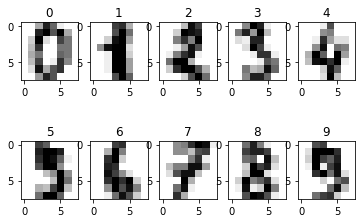

In [35]:
from sklearn import datasets

# (note: we overwrite the previous data here, make sure to reload it if you go back to part 1)
Xall, tall = datasets.load_digits(return_X_y=True)

print(Xall.shape)
print(np.unique(tall))

# print some examples of data from the dataset
for j in range(10):
    plt.subplot(2,5,j+1)
    plt.imshow(np.reshape(Xall[j,:], (8,8)), cmap=plt.cm.gray_r)
    plt.title("%d" % tall[j])
plt.show()

As you can see there are 1797 images arranged as 64-dimensional vectors, and defining 10 classes. In this case, the observed variables have many more dimensions, but we can use <i>multidimensional scaling</i> to visualise the distribution of the classes somehow (note that MDS on a large dataset can take a while).  

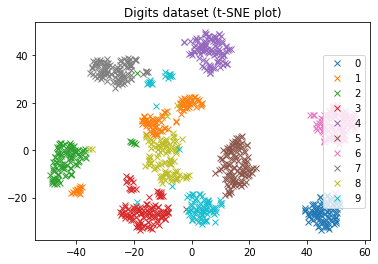

In [36]:
from sklearn.manifold import TSNE

# we select a subset of samples for speed 
Ntrain=1000
J = np.random.permutation(Xall.shape[0])[:Ntrain]
X = Xall[J,:]
t = tall[J]   # Features

# we then optimise the multidimensional scaling 
tsne = TSNE()
Xe = tsne.fit_transform(X)

# we then draw the classes on a 2D plot
for i in range(10):
    plt.plot(Xe[t==i,0], Xe[t==i,1], 'x', label='{}'.format(i))
plt.legend(loc='right')
plt.title('Digits dataset (t-SNE plot)')
plt.show()

This means that you have problem of <b>multiclass</b> classification. Some algorithms such as k-NN or MLPs can handle multiclass, whereas some other such as SVM need some additional work. 

In [37]:
#Example with k-NN:  

I = range(len(tall))    # you could change this for np.random.permutation(len(tall)) to get a random selection
                        # do not do this for this workshop as I want to be able to compare final performance. 

Itrain = I[:len(tall)//2]   # First half of indices for training
Itest = I[len(tall)//2:]    # Second half for test

Xtr = Xall[Itrain,:] # we define variables for the training set...
ttr = tall[Itrain]   

Xte = Xall[Itest,:]  # ... and for the test set
tte = tall[Itest]   

k = 5   # Choose the number of nearest neighbours

knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(Xtr, ttr)

# we can get the performance on the training set
Str = knn.score(Xtr, ttr)

# we can also calculate the performance on the test set: 
Ste = knn.score(Xte, tte)

print('Performance with k=%i,\n\t- on training set %f \n\t- on test set %f' % (k, Str, Ste))


Performance with k=5,
	- on training set 0.988864 
	- on test set 0.955506


In a multiclass setting it is often worth calculating another error measure: the confusion matrix. This matrix tells you where your error comes from and whether two classes are specially confused.  

Confusion matrix, without normalization


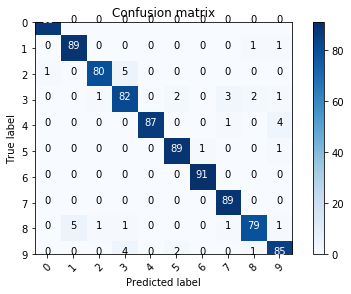

In [38]:
from sklearn import metrics
import itertools

from sklearn.metrics import confusion_matrix

# we predict the classes on the test data
pte = knn.predict(Xte)

# and we calculate the confusion matrix
cm = confusion_matrix(tte, pte)

np.set_printoptions(precision=2)


# code from: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
# now included in sklearn 0.22

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
plot_confusion_matrix(cm, np.unique(tte))

### 2.1 Digits with knn 
As a first shot, we will use the k-NN algorithm to try and model this dataset.
As we did before, use k-fold cross validation to find the best value of $k$. 
<div style="text-align: right"><b>[5 marks]</b></div>

Calculate the confusion matrix for the best parameter, show some examples of the misclassifications and try to explain the remaining errors. 
<div style="text-align: right"><b>[5 marks]</b></div>

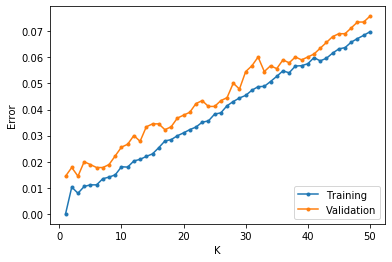

Best k is 3.0
Validation error is 0.014444444444444371


In [39]:
results = kTrainer()
plotKTrainer(results)
bestK(results);

Error is: 0.04449388209121241
Confusion matrix, without normalization


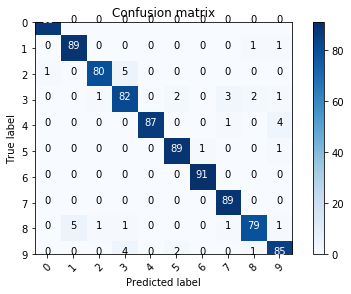

In [40]:
knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(Xtr, ttr)
pte = knn.predict(Xte)
print('Error is:', 1-knn.score(Xte, tte))
cm = confusion_matrix(tte, pte)
plot_confusion_matrix(cm, np.unique(tte))

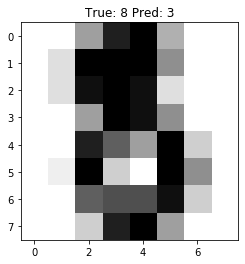

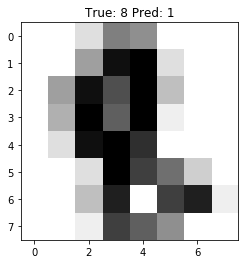

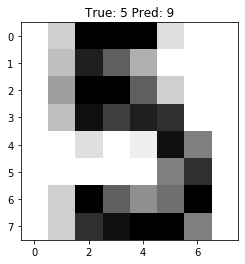

In [41]:
wrong = np.where(pte != tte)[0][:3]
for i in wrong:
    plt.title('True: %s Pred: %s' % (tte[i], pte[i]))
    plt.imshow(np.reshape(Xte[i], (8, 8)), cmap=plt.cm.gray_r)
    plt.show()

In [42]:
# In the first example there is not a clear hole for the top part of the 8.
# This has led to the prediction of the number 3

# The second example shows a fairly straight line down the center, this has been
# interpreted to be the center of the one.

# The final example is a 5 however the gap between the start of the curve and the
# top of the 5 is quite small which means the number is similar to a 9 which is
# what has been predicted.

### 2.2 Digits with MLP
As a second attempt 
As we did before, use k-fold cross validation to train an MLP on this data, optimising regularisation parameter $\alpha$ and the number of hidden units. 
<div style="text-align: right"><b>[10 marks]</b></div>

Calculate the confusion matrix for the best parameter, show some examples of the misclassifications and try to explain the remaining errors. 
<div style="text-align: right"><b>[5 marks]</b></div>

In [43]:
results = alphaTrainer(30, 5, 10)

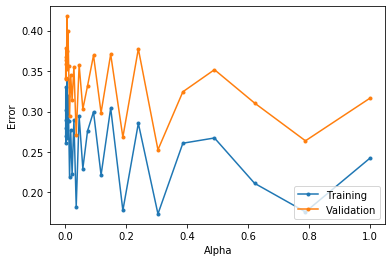

In [44]:
plotAlpha(results)

In [45]:
alpha = bestAlpha(results)

Best alpha is 0.3039195382313198
Validation error is 0.2526841448189764


Error is: 0.24805339265850945
Confusion matrix, without normalization


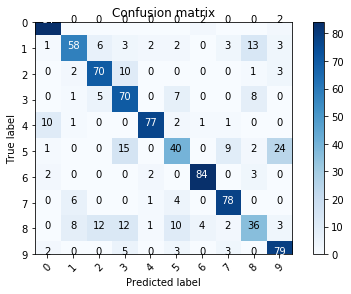

In [46]:
Ebest = np.Inf
for n in range(10):
    mlp = MLPClassifier(solver='lbfgs', alpha=alpha, hidden_layer_sizes=(5,))
    mlp.fit(Xtr, ttr)
    if mlp.loss_ < Ebest:
        mlpbest = mlp
        Ebest = mlp.loss_
mlp = mlpbest

pte = mlp.predict(Xte)
print('Error is:', 1-mlp.score(Xte, tte))
cm = confusion_matrix(tte, pte)
plot_confusion_matrix(cm, np.unique(tte))

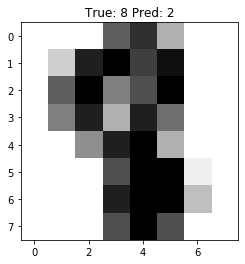

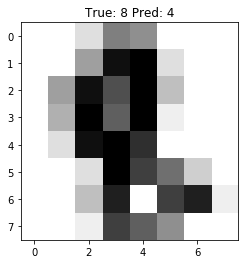

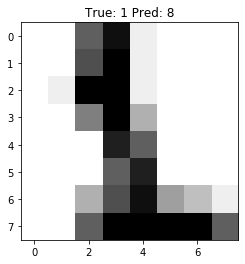

In [47]:
wrong = np.where(pte != tte)[0][:3]
for i in wrong:
    plt.title('True: %s Pred: %s' % (tte[i], pte[i]))
    plt.imshow(np.reshape(Xte[i], (8, 8)), cmap=plt.cm.gray_r)
    plt.show()

In [48]:
# The first error was due to the 8 not having a clear hole in the top which resulted in only one O being found,
# the classifier then predicted this was a zero.

# The second example is a 9 however the tail on the end of the 9 is quite long and high which is why it has been
# predicted to be an 8.

# The final example is an image that was predicted to be a 1 but was an 8, the 8 was drawn narrow and only partially
# connects at the top and bottom.

In [51]:
from sklearn.multiclass import OneVsRestClassifier

def svmTrainerComplex(kernel='linear', folds=10):
    
    # List to store results.
    results = []

    # Repeat for different values of k.
    for c in np.logspace(-5, 1, 7):
        print(c)
        for g in np.logspace(-5, 3, 9):

            # Split data.
            kf = KFold(n_splits=folds, shuffle=True, random_state=0)

            # Variables to hold combined score of classifier
            trainScore = 0
            validationScore = 0

            # Runs loop for every fold.
            for train, validation in kf.split(Xtr):

                # Train classifier and work out score.
                svm = OneVsRestClassifier(SVC(kernel=kernel, C=c, gamma=g, probability=True))
                svm.fit(Xtr[train], ttr[train])
                trainScore += svm.score(Xtr[train], ttr[train])
                validationScore += svm.score(Xtr[validation], ttr[validation])

            # Compute averages
            trainScore /= folds
            validationScore /= folds

            # Append results.
            results.append((c, g, 1-trainScore, 1-validationScore))

    return np.array(results)

1e-05
0.0001
0.001
0.01
0.1
1.0
10.0


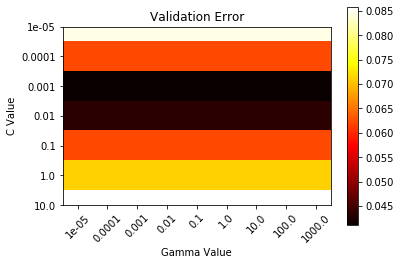

C: 0.001
Gamma: 1e-05
Validation Error: 0.041186017478152315


In [52]:
results = svmTrainerComplex('linear')
plotSVMResults(results)
best = bestCGamma(results)

1e-05
0.0001
0.001
0.01
0.1
1.0
10.0


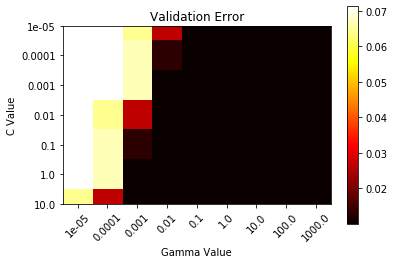

C: 1e-05
Gamma: 0.1
Validation Error: 0.010012484394506749


In [53]:
results = svmTrainerComplex('poly')
plotSVMResults(results)
best = bestCGamma(results)

Calculate the confusion matrix for the best parameter, show some examples of the misclassifications and try to explain the remaining errors. 
<div style="text-align: right"><b>[5 marks]</b></div>

Error is: 0.12013348164627369
Confusion matrix, without normalization


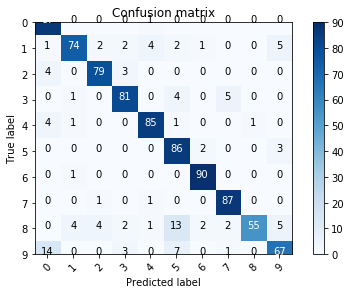

In [58]:
svm = OneVsRestClassifier(SVC(kernel='linear', C=0.001, gamma=1e-05))
svm.fit(Xtr, ttr)
pte = svm.predict(Xte)
print('Error is:', 1-svm.score(Xte, tte))
cm = confusion_matrix(tte, pte)
plot_confusion_matrix(cm, np.unique(tte))

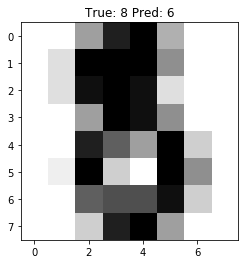

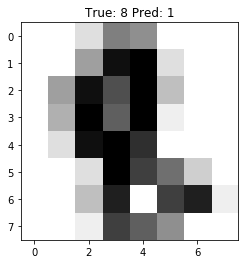

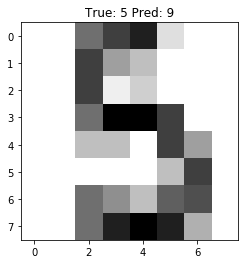

In [55]:
wrong = np.where(pte != tte)[0][:3]
for i in wrong:
    plt.title('True: %s Pred: %s' % (tte[i], pte[i]))
    plt.imshow(np.reshape(Xte[i], (8, 8)), cmap=plt.cm.gray_r)
    plt.show()

In [56]:
# The misclassifications above are similar to the other ones I have encountered. The first is missing the top
# O of the 8 but has a wide line which has been interpreted to be a 6.

# For the second example again the top O is not clear and looks to be slightly rotated creating a straight
# line down the middle and therefore appears to be a 1 instead of an 8.

# The third example is supposed to be a 5 but there is a slight connection of the top to the curve on the
# side and therefore has been classified as a 9.

Error is: 0.04115684093437155
Confusion matrix, without normalization


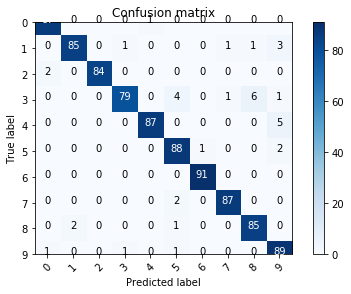

In [59]:
svm = OneVsRestClassifier(SVC(kernel='poly', C=1e-05, gamma=0.1))
svm.fit(Xtr, ttr)
pte = svm.predict(Xte)
print('Error is:', 1-svm.score(Xte, tte))
cm = confusion_matrix(tte, pte)
plot_confusion_matrix(cm, np.unique(tte))

Compare performance of all 3 algorithms for this problem. Discuss the differences in the remaining errors and what would be your suggestion going forward with this dataset. 
<div style="text-align: right"><b>[10 marks]</b></div>

The first method using k-nearest neighbours was very sucesfull in clustering the data, as I was able to achieve a solid result of only 4.45% error. The second algorithm was using a multi-layer perceptron which did not perform as well as the others achieving an error of 27.7%. The final algorithm used was a support vector classifier, there were 2 variations of this that I used, the first was using a linear kernel giving an error of 7.45% compared to a polynomial kernel which achieved a resultant error of 4.12%. So in this case the best performing algorihtm was the polynomial support vector machine. To improve the accuracy on the dataset there needs to be higher resolution images taken or individual letters because currently there is a lot of guesswork because there is only 64 pixels which is not enough to capture the detail of something as complex as a letter that can be done multiple ways.